In [1]:
import pandas as pd

In [14]:
# Load data
# https://towardsdatascience.com/performing-a-time-series-analysis-on-the-aapl-stock-index-3655da9612ff
df = pd.read_csv("../dataset/data/2000-2020/AAPL_2000-01-01_to_2020-10-31.csv")
df.dtypes

Date          object
High         float64
Low          float64
Open         float64
Close        float64
Volume       float64
Adj Close    float64
Ticker        object
dtype: object

In [4]:
# Convert the Date object to DateTime
from datetime import datetime
con = df['Date']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)
df.index

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2020-10-19', '2020-10-20', '2020-10-21', '2020-10-22',
               '2020-10-23', '2020-10-26', '2020-10-27', '2020-10-28',
               '2020-10-29', '2020-10-30'],
              dtype='datetime64[ns]', name='Date', length=5242, freq=None)

In [6]:
#Extract year, month and day from date for analysis
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day

In [7]:
df.sample(5,random_state=0)

,High,Low,Open,Close,Volume,Adj Close,Ticker,Year,Month,Day
Date,,,,,,,,,,
2014-11-14,28.547501,27.802500,28.287500,28.545000,1.762544e+08,25.791906,AAPL,2014,11,14
2010-07-06,9.028571,8.791429,8.964286,8.879642,6.152356e+08,7.597826,AAPL,2010,7,6
2007-03-05,3.166071,3.062857,3.067500,3.082857,8.388996e+08,2.637832,AAPL,2007,3,5
2019-12-12,68.139999,66.830002,66.945000,67.864998,1.373104e+08,66.737518,AAPL,2019,12,12
2006-08-07,2.485714,2.368214,2.418571,2.400357,1.245513e+09,2.053855,AAPL,2006,8,7


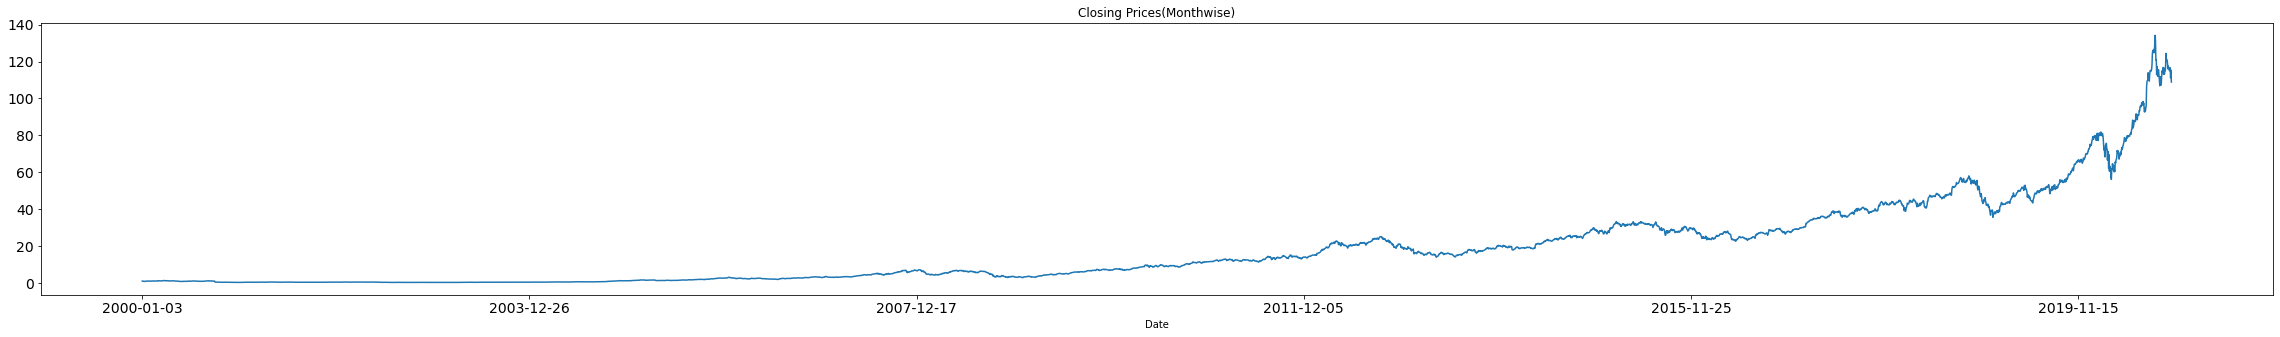

In [18]:
'''
The hypothesis was 1. The sales are high during Christmas holidays season 2. There will be increase in closing price from Sept to Oct 3. Stock prices tend to increase in January
'''
temp=df.groupby('Date')['Close'].mean() 
temp.plot(figsize=(40,5), title= 'Closing Prices(Monthwise)', fontsize=14)

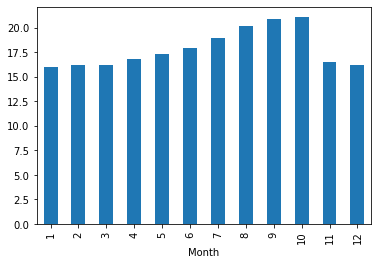

In [11]:
df.groupby('Month')['Close'].mean().plot.bar()

In [ ]:
'''
From the above two graphs it is clear that only hypothesis 2 was true as highest sales were recorded during Oct.
'''

In [13]:
df.shape

(5242, 10)

In [23]:
train = df[:5032]
test = df[5033:]

In [24]:
'''
Next step is to ensure the data is stationary. There are 3 criterion to ensure this:
1. Mean of the time series should not be a function of time.It should be constant
2. Variance should not be a function of time.
3. Covariance of the ith term and (i+m)th term should not be a function of time.
To make our data stationary we need to remove trend and seasonality.

Steps to make it stationary:
1. Dickey Fuller Test
2. null hypothesis is that the time series is not stationary ie has some time dependent feature
3. alternate hypothesis is that time series is stationary.

'''

'\nNext step is to ensure the data is stationary. There are 3 criterion to ensure this:\n1. Mean of the time series should not be a function of time.It should be constant\n2. Variance should not be a function of time.\n3. Covariance of the ith term and (i+m)th term should not be a function of time.\nTo make our data stationary we need to remove trend and seasonality.\n\nSteps to make it stationary:\n1. Dickey Fuller Test\n2. null hypothesis is that the time series is not stationary ie has some time dependent feature\n3. alternate hypothesis is that time series is stationary.\n\n'

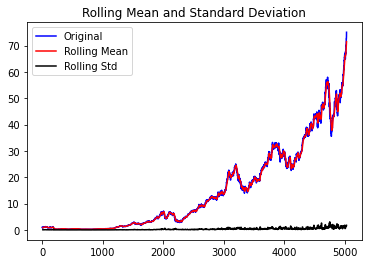

Results of dickey fuller test
Test Statistics                   2.680759
p-value                           0.999086
No. of lags used                 29.000000
Number of observations used    5002.000000
critical value (1%)              -3.431658
critical value (5%)              -2.862118
critical value (10%)             -2.567078
dtype: float64


In [27]:
# Dickey Fuller test
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print('Results of dickey fuller test')
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] = values
    print(output)
 
test_stationarity(train['Close'])

In [ ]:
'''
Test Statistics > Critical Value
p-value > critical value
This means the series is not stationary. We need to remove trend and seasonality for this
'''

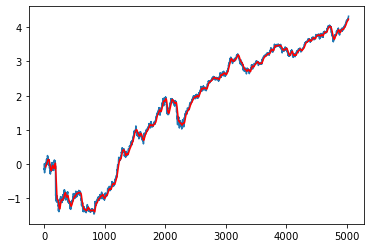

In [55]:
# removing trend
# we see that there is an uptrend in the series. We apply log transformation to penalize higher values more than lower ones. 
import numpy as np
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])
moving_avg = train_log.rolling(25).mean() 
plt.plot(train_log) 
plt.plot(moving_avg, color = 'red') 
plt.show()

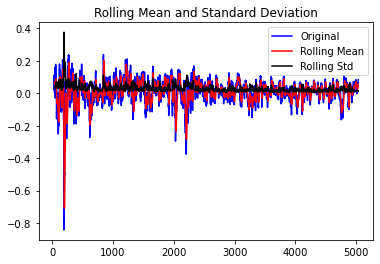

Results of dickey fuller test
Test Statistics               -9.594427e+00
p-value                        1.995900e-16
No. of lags used               2.400000e+01
Number of observations used    4.983000e+03
critical value (1%)           -3.431663e+00
critical value (5%)           -2.862120e+00
critical value (10%)          -2.567079e+00
dtype: float64


In [56]:
train_log_moving_avg_diff = train_log - moving_avg
# since we took a rolling average for 24 records, first 23 samples do not have rolling mean, we can safely drop those samples.abs
train_log_moving_avg_diff.dropna(inplace = True)
test_stationarity(train_log_moving_avg_diff)


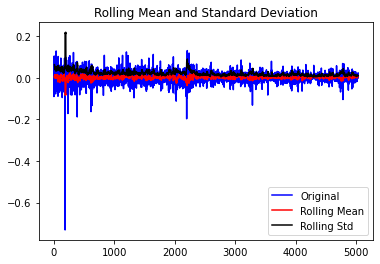

Results of dickey fuller test
Test Statistics               -1.498584e+01
p-value                        1.144212e-27
No. of lags used               2.000000e+01
Number of observations used    5.010000e+03
critical value (1%)           -3.431656e+00
critical value (5%)           -2.862117e+00
critical value (10%)          -2.567077e+00
dtype: float64


In [57]:
# now test statistics<critical value. p-value. Stabilizing mean of the time series. 
train_log_diff = train_log - train_log.shift(1) 
test_stationarity(train_log_diff.dropna())

In [60]:
# removing periodic fluctuations.
# using seasonality decompose to decompose time series into trend, seasonality and residuals.
train_log_decompose = pd.DataFrame(residual) 
train_log_decompose['date'] = train_log.index 
train_log_decompose.set_index('date', inplace = True) 
train_log_decompose.dropna(inplace=True) 
test_stationarity(train_log_decompose[0])
train_log_decompose = pd.DataFrame(residual) 
train_log_decompose['date'] = train_log.index 
train_log_decompose.set_index('date', inplace = True)
train_log_decompose.dropna(inplace=True) 
test_stationarity(train_log_decompose[0])

NameError: name 'residual' is not defined